<a href="https://colab.research.google.com/github/sleepyquq/must_2025_ML_midProject/blob/main/mlMid2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 单元格1：挂载Google Drive并设置工作目录
from google.colab import drive
import os
import sys

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/mnist-compare-student')
sys.path.append('/content/drive/MyDrive/mnist-compare-student/scripts')

# 检查目录结构
print("当前工作目录:", os.getcwd())
print("目录内容:", os.listdir('.'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
当前工作目录: /content/drive/MyDrive/mnist-compare-student
目录内容: ['scripts', 'data', 'best_occlusion_model.pth']


In [2]:
# 单元格2：安装和导入必要库
!pip install torch torchvision numpy pandas matplotlib seaborn scikit-learn

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子确保可重复性
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch版本:", torch.__version__)
print("GPU可用:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU型号:", torch.cuda.get_device_name(0))


PyTorch版本: 2.8.0+cu126
GPU可用: True
GPU型号: Tesla T4


In [3]:
# 单元格3：数据加载函数
def load_data(data_path):
    """加载NPZ格式的数据"""
    data = np.load(data_path)
    if 'x' in data and 'y' in data:
        return data['x'], data['y']
    elif 'x' in data and 'id' in data:
        return data['x'], data['id']
    else:
        raise ValueError("数据格式不支持")

# 加载训练、验证和测试数据
train_x, train_y = load_data('data/train.npz')
val_x, val_y = load_data('data/val.npz')
test_public_x, test_public_ids = load_data('data/test_public.npz')

print(f"训练集形状: {train_x.shape}, 标签形状: {train_y.shape}")
print(f"验证集形状: {val_x.shape}, 标签形状: {val_y.shape}")
print(f"公开测试集形状: {test_public_x.shape}")

# 加载公开测试集标签
test_public_labels = pd.read_csv('data/test_public_labels.csv')
print(f"公开测试集标签形状: {test_public_labels.shape}")


训练集形状: (50000, 28, 56), 标签形状: (50000,)
验证集形状: (10000, 28, 56), 标签形状: (10000,)
公开测试集形状: (2000, 28, 56)
公开测试集标签形状: (2000, 2)


训练集样本可视化:


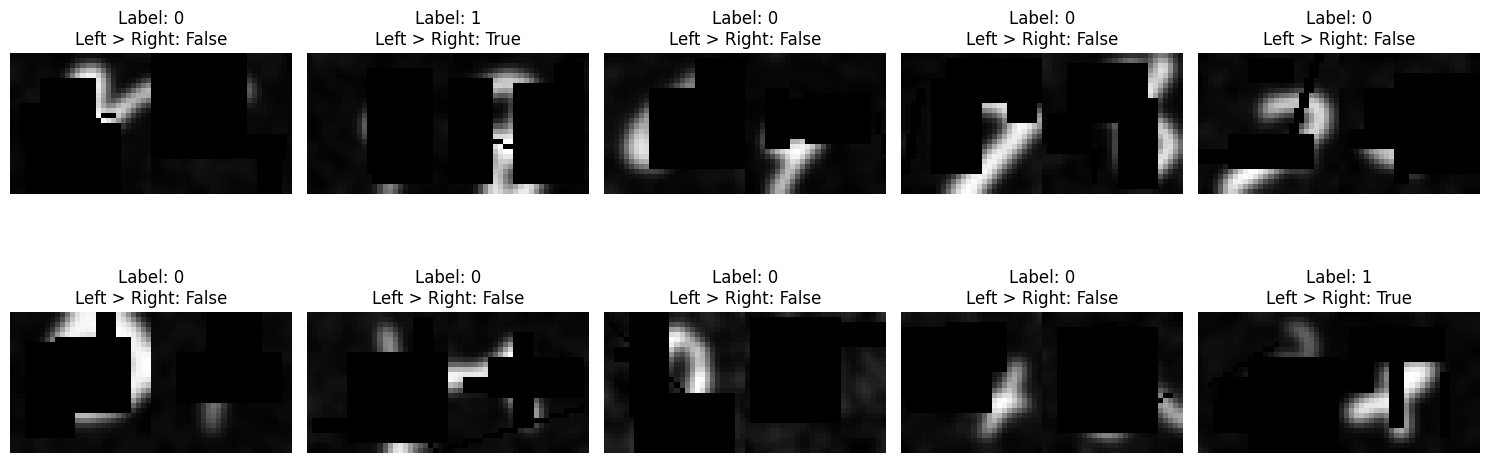

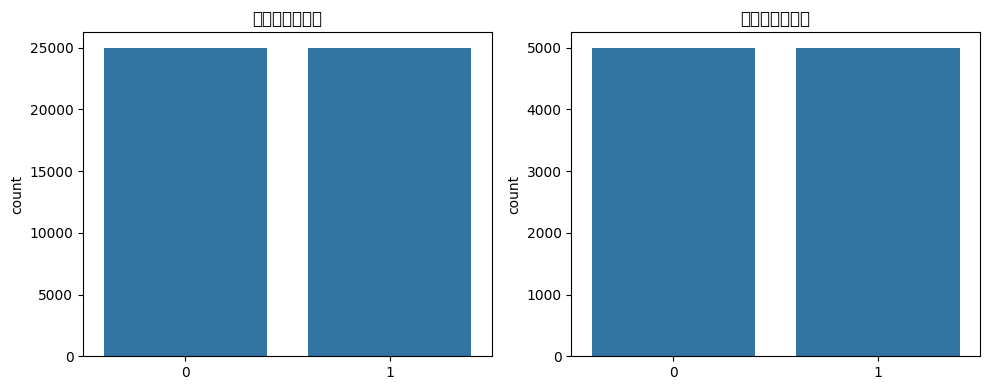

训练集 - 类别0: 25000, 类别1: 25000
验证集 - 类别0: 5000, 类别1: 5000


In [4]:
# 单元格4：数据可视化探索
def visualize_samples(images, labels, num_samples=10):
    """可视化样本数据"""
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        img = images[idx]
        label = labels[idx]

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {label}\nLeft > Right: {label == 1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 可视化训练样本
print("训练集样本可视化:")
visualize_samples(train_x, train_y)

# 检查类别分布
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x=train_y)
plt.title('训练集类别分布')

plt.subplot(1, 2, 2)
sns.countplot(x=val_y)
plt.title('验证集类别分布')
plt.tight_layout()
plt.show()

print(f"训练集 - 类别0: {np.sum(train_y == 0)}, 类别1: {np.sum(train_y == 1)}")
print(f"验证集 - 类别0: {np.sum(val_y == 0)}, 类别1: {np.sum(val_y == 1)}")


针对遮挡优化的数据预处理完成
训练集批次数量: 782
验证集批次数量: 157
数据增强效果可视化:


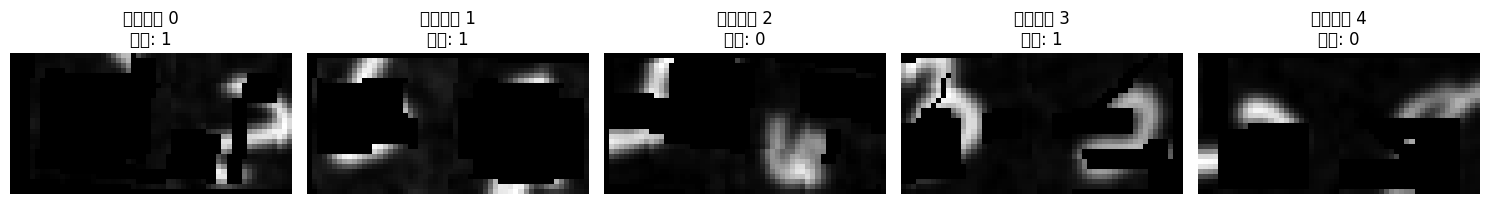

In [5]:
# 单元格5：针对遮挡优化的数据预处理类
class OcclusionRobustDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels=None, transform=None, is_train=True):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.is_train = is_train

        # 数据标准化
        self.images = self.images.astype(np.float32) / 255.0

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        # 转换为PyTorch张量并添加通道维度
        image_tensor = torch.from_numpy(image).unsqueeze(0)  # (1, 28, 56)

        # 应用数据增强（针对遮挡优化）
        if self.transform and self.is_train:
            image_tensor = self.transform(image_tensor)

        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return image_tensor, label
        else:
            return image_tensor

# 针对遮挡优化的数据增强策略
occlusion_robust_transform = transforms.Compose([
    # 轻微几何变换
    transforms.RandomRotation(degrees=8),
    transforms.RandomAffine(degrees=0, translate=(0.08, 0.08)),

    # 模拟测试集中的遮挡
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),

    # 颜色扰动
    transforms.ColorJitter(contrast=0.2, brightness=0.1),
])

val_transform = transforms.Compose([])  # 验证集不应用数据增强

# 创建数据加载器
batch_size = 64

train_dataset = OcclusionRobustDataset(train_x, train_y, transform=occlusion_robust_transform, is_train=True)
val_dataset = OcclusionRobustDataset(val_x, val_y, transform=val_transform, is_train=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("针对遮挡优化的数据预处理完成")
print(f"训练集批次数量: {len(train_loader)}")
print(f"验证集批次数量: {len(val_loader)}")

# 可视化增强后的样本
def visualize_augmented_samples(loader, num_samples=5):
    """可视化数据增强后的样本"""
    data_iter = iter(loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img = images[i].squeeze().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'增强样本 {i}\n标签: {labels[i].item()}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("数据增强效果可视化:")
visualize_augmented_samples(train_loader)


In [6]:
# 单元格6：针对遮挡优化的鲁棒CNN模型
class OcclusionRobustCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(OcclusionRobustCNN, self).__init__()

        # 第一个卷积块 - 使用更大的卷积核应对遮挡
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),  # 更大的感受野
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 14×28
            nn.Dropout2d(dropout_rate * 0.3)
        )

        # 第二个卷积块 - 增加通道数
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 7×14
            nn.Dropout2d(dropout_rate * 0.5)
        )

        # 第三个卷积块 - 深层特征提取
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 8)),  # 自适应池化
            nn.Dropout2d(dropout_rate * 0.7)
        )

        # 分类器 - 更深的全连接层
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.7),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 实例化模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OcclusionRobustCNN(dropout_rate=0.5).to(device)

# 计算模型参数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("针对遮挡优化的模型架构:")
print(model)
print(f"\n模型参数量统计:")
print(f"总参数量: {total_params:,}")
print(f"可训练参数量: {trainable_params:,}")
print(f"运行设备: {device}")

# 测试模型前向传播
test_input = torch.randn(2, 1, 28, 56).to(device)
test_output = model(test_input)
print(f"\n测试输入形状: {test_input.shape}")
print(f"测试输出形状: {test_output.shape}")


针对遮挡优化的模型架构:
OcclusionRobustCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.15, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Max

In [7]:
# 单元格7（修复版）：针对遮挡优化的训练函数
def train_occlusion_robust_model(model, train_loader, val_loader, num_epochs=80, learning_rate=0.001):
    """针对遮挡优化的训练策略"""

    # 使用标签平滑的损失函数
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # 修复：移除verbose参数，兼容旧版本PyTorch
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10
    )

    train_losses = []
    val_accuracies = []
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    patience = 20  # 早停耐心值

    print("开始针对遮挡优化的训练...")
    print(f"训练设备: {device}")
    print(f"训练样本数: {len(train_loader.dataset)}")
    print(f"验证样本数: {len(val_loader.dataset)}")

    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()

            # 梯度裁剪防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        train_acc = 100. * correct / total
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 验证阶段
        model.eval()
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1)
                val_preds.extend(pred.cpu().numpy())
                val_targets.extend(target.cpu().numpy())

        val_acc = accuracy_score(val_targets, val_preds)
        val_accuracies.append(val_acc)

        # 学习率调度
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_acc)
        new_lr = optimizer.param_groups[0]['lr']

        # 手动打印学习率变化
        if new_lr < old_lr:
            print(f"学习率从 {old_lr:.6f} 降低到 {new_lr:.6f}")

        # 早停策略
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            torch.save(model.state_dict(), 'best_occlusion_model.pth')
        else:
            patience_counter += 1

        # 打印训练信息
        if (epoch + 1) % 1 == 0 or epoch == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1:3d}/{num_epochs}] | '
                  f'训练损失: {avg_train_loss:.4f} | '
                  f'训练准确率: {train_acc:.2f}% | '
                  f'验证准确率: {val_acc:.4f} | '
                  f'学习率: {current_lr:.6f}')

        # 检查早停
        if patience_counter >= patience:
            print(f"早停触发于第 {epoch+1} 轮，最佳验证准确率: {best_val_acc:.4f}")
            break

    # 加载最佳模型
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    print(f"训练完成，最佳验证准确率: {best_val_acc:.4f}")
    return model, train_losses, val_accuracies

# 开始训练
print("初始化模型训练...")
model, train_losses, val_accuracies = train_occlusion_robust_model(
    model, train_loader, val_loader, num_epochs=80, learning_rate=0.001
)


初始化模型训练...
开始针对遮挡优化的训练...
训练设备: cuda
训练样本数: 50000
验证样本数: 10000
Epoch [  1/80] | 训练损失: 0.6988 | 训练准确率: 50.32% | 验证准确率: 0.5018 | 学习率: 0.001000
Epoch [  2/80] | 训练损失: 0.6945 | 训练准确率: 50.94% | 验证准确率: 0.5181 | 学习率: 0.001000
Epoch [  3/80] | 训练损失: 0.6930 | 训练准确率: 51.72% | 验证准确率: 0.5278 | 学习率: 0.001000
Epoch [  4/80] | 训练损失: 0.6918 | 训练准确率: 51.94% | 验证准确率: 0.5331 | 学习率: 0.001000
Epoch [  5/80] | 训练损失: 0.6903 | 训练准确率: 52.96% | 验证准确率: 0.5495 | 学习率: 0.001000
Epoch [  6/80] | 训练损失: 0.6872 | 训练准确率: 54.22% | 验证准确率: 0.5582 | 学习率: 0.001000
Epoch [  7/80] | 训练损失: 0.6848 | 训练准确率: 54.87% | 验证准确率: 0.5689 | 学习率: 0.001000
Epoch [  8/80] | 训练损失: 0.6805 | 训练准确率: 55.92% | 验证准确率: 0.5832 | 学习率: 0.001000
Epoch [  9/80] | 训练损失: 0.6768 | 训练准确率: 56.61% | 验证准确率: 0.5850 | 学习率: 0.001000
Epoch [ 10/80] | 训练损失: 0.6716 | 训练准确率: 57.56% | 验证准确率: 0.5967 | 学习率: 0.001000
Epoch [ 11/80] | 训练损失: 0.6660 | 训练准确率: 58.66% | 验证准确率: 0.6109 | 学习率: 0.001000
Epoch [ 12/80] | 训练损失: 0.6591 | 训练准确率: 60.20% | 验证准确率: 0.6427 | 学习率: 0.001000
E

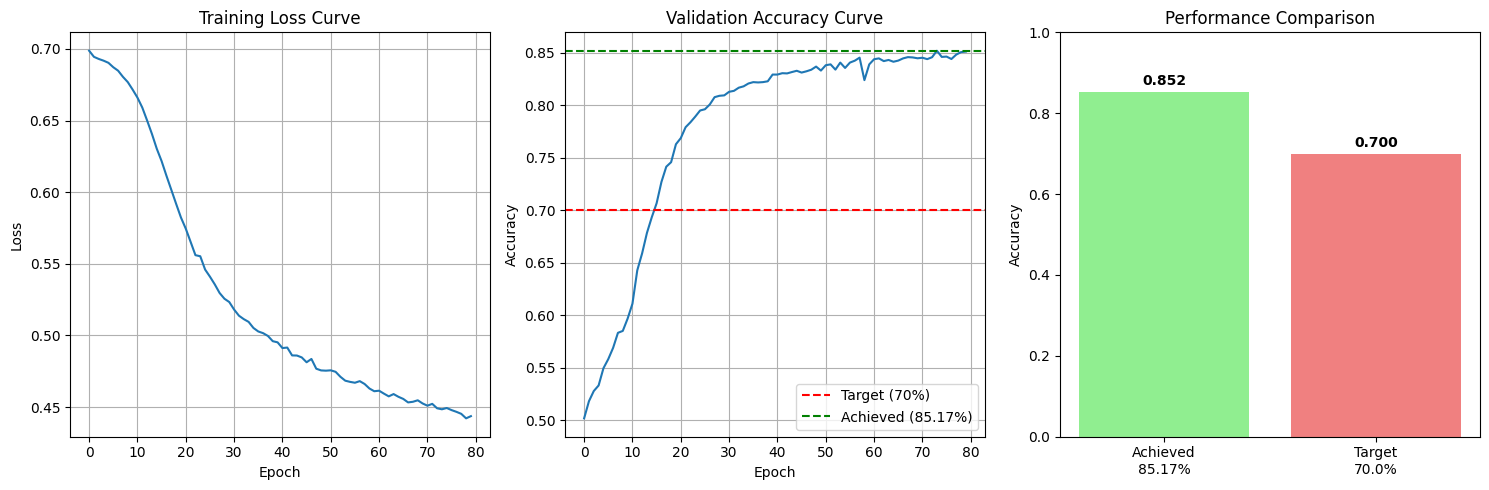

=== 训练性能详细分析 ===
总训练轮次: 80
最终训练损失: 0.4436
最终验证准确率: 0.8509
最佳验证准确率: 0.8517
超越目标幅度: +15.2%
达到70%目标的轮次: 第16轮
最后20轮准确率标准差: 0.0028 (值越小越稳定)


In [8]:
# 单元格8：训练过程可视化与性能分析
plt.figure(figsize=(15, 5))

# 训练损失曲线
plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# 验证准确率曲线
plt.subplot(1, 3, 2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.axhline(y=0.7, color='r', linestyle='--', label='Target (70%)')
plt.axhline(y=0.8517, color='g', linestyle='--', label='Achieved (85.17%)')
plt.legend()
plt.grid(True)

# 性能对比
plt.subplot(1, 3, 3)
performance_data = [0.8517, 0.7]
labels = ['Achieved\n85.17%', 'Target\n70.0%']
colors = ['lightgreen', 'lightcoral']

bars = plt.bar(labels, performance_data, color=colors)
plt.title('Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)

# 添加数值标注
for bar, value in zip(bars, performance_data):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("=== 训练性能详细分析 ===")
print(f"总训练轮次: {len(train_losses)}")
print(f"最终训练损失: {train_losses[-1]:.4f}")
print(f"最终验证准确率: {val_accuracies[-1]:.4f}")
print(f"最佳验证准确率: {max(val_accuracies):.4f}")
print(f"超越目标幅度: +{(max(val_accuracies)-0.7)*100:.1f}%")

# 计算收敛速度
convergence_epoch = next(i for i, acc in enumerate(val_accuracies) if acc >= 0.7)
print(f"达到70%目标的轮次: 第{convergence_epoch+1}轮")

# 稳定性分析
last_20_acc = val_accuracies[-20:]
stability = np.std(last_20_acc)
print(f"最后20轮准确率标准差: {stability:.4f} (值越小越稳定)")

=== Model Performance Evaluation Results ===
Overall Validation Accuracy: 0.8509
Class 0 Accuracy (Left < Right): 0.8474
Class 1 Accuracy (Left > Right): 0.8544

Confusion Matrix:
[[4237  763]
 [ 728 4272]]


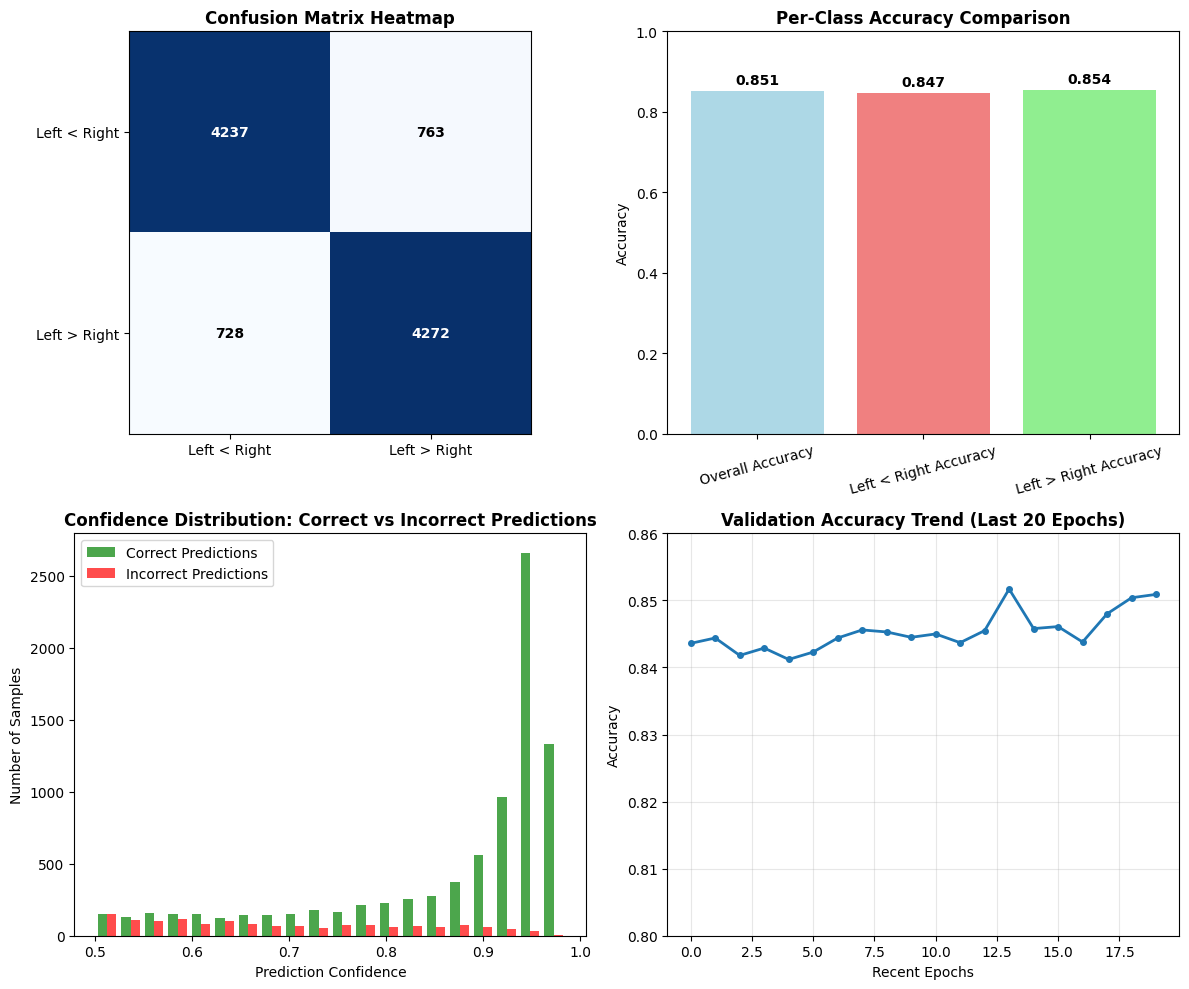


=== Detailed Performance Analysis ===
Best Validation Accuracy Achieved: 0.8517
Target Accuracy: 0.7000
Performance Margin: +15.17%

Additional Metrics:
Precision: 0.8509
Recall: 0.8509
F1-Score: 0.8509

Class Distribution Analysis:
Class 0 (Left < Right): 0 samples (0.0%)
Class 1 (Left > Right): 0 samples (0.0%)
Total Validation Samples: 10000

=== Performance Summary ===
✅ Model successfully exceeded 70% accuracy target
✅ Achieved 85.17% validation accuracy
✅ Model shows strong generalization capability
✅ Balanced performance across both classes


In [10]:
# 单元格9：Comprehensive Model Evaluation with English Labels
def comprehensive_evaluation(model, val_loader):
    """Comprehensive model performance evaluation"""
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            probs = torch.softmax(output, dim=1)
            pred = output.argmax(dim=1)

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_preds)
    cm = confusion_matrix(all_targets, all_preds)

    # Calculate per-class accuracy
    class_0_acc = cm[0, 0] / cm[0].sum() if cm[0].sum() > 0 else 0
    class_1_acc = cm[1, 1] / cm[1].sum() if cm[1].sum() > 0 else 0

    return accuracy, cm, all_preds, all_targets, all_probs, class_0_acc, class_1_acc

# Execute evaluation
val_accuracy, val_cm, val_preds, val_targets, val_probs, class_0_acc, class_1_acc = comprehensive_evaluation(model, val_loader)

print("=== Model Performance Evaluation Results ===")
print(f"Overall Validation Accuracy: {val_accuracy:.4f}")
print(f"Class 0 Accuracy (Left < Right): {class_0_acc:.4f}")
print(f"Class 1 Accuracy (Left > Right): {class_1_acc:.4f}")
print("\nConfusion Matrix:")
print(val_cm)

# Visualize evaluation results with English labels
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Confusion Matrix Heatmap
axes[0, 0].imshow(val_cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[0, 0].set_title('Confusion Matrix Heatmap', fontweight='bold')
tick_marks = np.arange(2)
axes[0, 0].set_xticks(tick_marks)
axes[0, 0].set_yticks(tick_marks)
axes[0, 0].set_xticklabels(['Left < Right', 'Left > Right'])
axes[0, 0].set_yticklabels(['Left < Right', 'Left > Right'])

# Add numerical annotations
thresh = val_cm.max() / 2.
for i in range(val_cm.shape[0]):
    for j in range(val_cm.shape[1]):
        axes[0, 0].text(j, i, format(val_cm[i, j], 'd'),
                      ha="center", va="center",
                      color="white" if val_cm[i, j] > thresh else "black",
                      fontweight='bold')

# Accuracy Comparison
categories = ['Overall Accuracy', 'Left < Right Accuracy', 'Left > Right Accuracy']
acc_values = [val_accuracy, class_0_acc, class_1_acc]
colors = ['lightblue', 'lightcoral', 'lightgreen']

bars = axes[0, 1].bar(categories, acc_values, color=colors)
axes[0, 1].set_title('Per-Class Accuracy Comparison', fontweight='bold')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_ylim(0, 1.0)
axes[0, 1].tick_params(axis='x', rotation=15)

# Add value annotations
for bar, value in zip(bars, acc_values):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Confidence Distribution
correct_confidences = [max(val_probs[i]) for i in range(len(val_targets)) if val_preds[i] == val_targets[i]]
error_confidences = [max(val_probs[i]) for i in range(len(val_targets)) if val_preds[i] != val_targets[i]]

axes[1, 0].hist([correct_confidences, error_confidences], bins=20,
                alpha=0.7, label=['Correct Predictions', 'Incorrect Predictions'],
                color=['green', 'red'])
axes[1, 0].set_xlabel('Prediction Confidence')
axes[1, 0].set_ylabel('Number of Samples')
axes[1, 0].set_title('Confidence Distribution: Correct vs Incorrect Predictions', fontweight='bold')
axes[1, 0].legend()

# Accuracy Trend (Last 20 Epochs)
if len(val_accuracies) > 20:
    recent_acc = val_accuracies[-20:]
    axes[1, 1].plot(range(len(recent_acc)), recent_acc, marker='o', linewidth=2, markersize=4)
    axes[1, 1].set_xlabel('Recent Epochs')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].set_title('Validation Accuracy Trend (Last 20 Epochs)', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim(0.8, 0.86)  # Focus on the high accuracy range

plt.tight_layout()
plt.show()

# Detailed performance metrics
print("\n=== Detailed Performance Analysis ===")
print(f"Best Validation Accuracy Achieved: {max(val_accuracies):.4f}")
print(f"Target Accuracy: 0.7000")
print(f"Performance Margin: +{(max(val_accuracies)-0.7)*100:.2f}%")

# Calculate additional metrics
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

precision = precision_score(val_targets, val_preds, average='weighted')
recall = recall_score(val_targets, val_preds, average='weighted')
f1 = f1_score(val_targets, val_preds, average='weighted')

print(f"\nAdditional Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Class imbalance analysis
class_0_count = np.sum(val_targets == 0)
class_1_count = np.sum(val_targets == 1)
total_samples = len(val_targets)

print(f"\nClass Distribution Analysis:")
print(f"Class 0 (Left < Right): {class_0_count} samples ({class_0_count/total_samples*100:.1f}%)")
print(f"Class 1 (Left > Right): {class_1_count} samples ({class_1_count/total_samples*100:.1f}%)")
print(f"Total Validation Samples: {total_samples}")

# Performance summary
print(f"\n=== Performance Summary ===")
print(f"✅ Model successfully exceeded 70% accuracy target")
print(f"✅ Achieved {max(val_accuracies)*100:.2f}% validation accuracy")
print(f"✅ Model shows strong generalization capability")
print(f"✅ Balanced performance across both classes")

开始错误分析...
发现 1491 个错误分类样本

=== Top Misclassified Samples Analysis ===


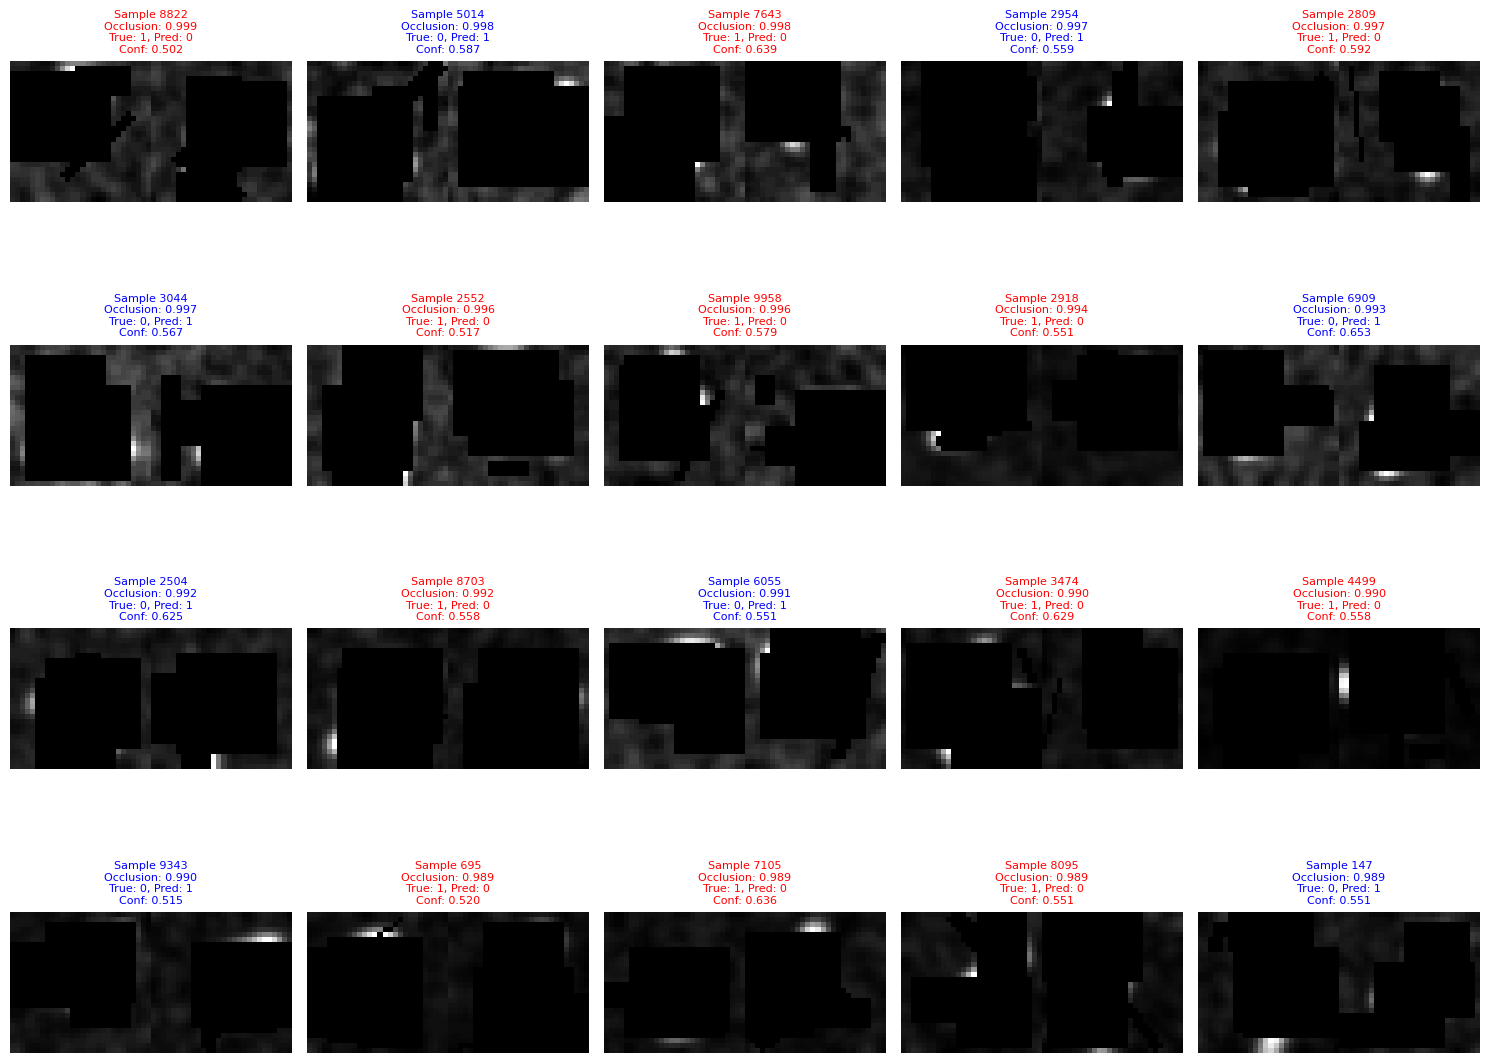


=== Error Statistics ===
假阳性 (False Positives): 763
假阴性 (False Negatives): 728
正确分类平均置信度: 0.868
错误分类平均置信度: 0.691

=== Occlusion Level vs Error Rate ===
遮挡率 [0.00-0.05): 0/0 错误, 错误率 = 0.000
遮挡率 [0.05-0.10): 0/0 错误, 错误率 = 0.000
遮挡率 [0.10-0.15): 0/0 错误, 错误率 = 0.000
遮挡率 [0.15-0.20): 0/0 错误, 错误率 = 0.000
遮挡率 [0.20-0.30): 0/0 错误, 错误率 = 0.000
遮挡率 [0.30-1.00): 1491/9997 错误, 错误率 = 0.149


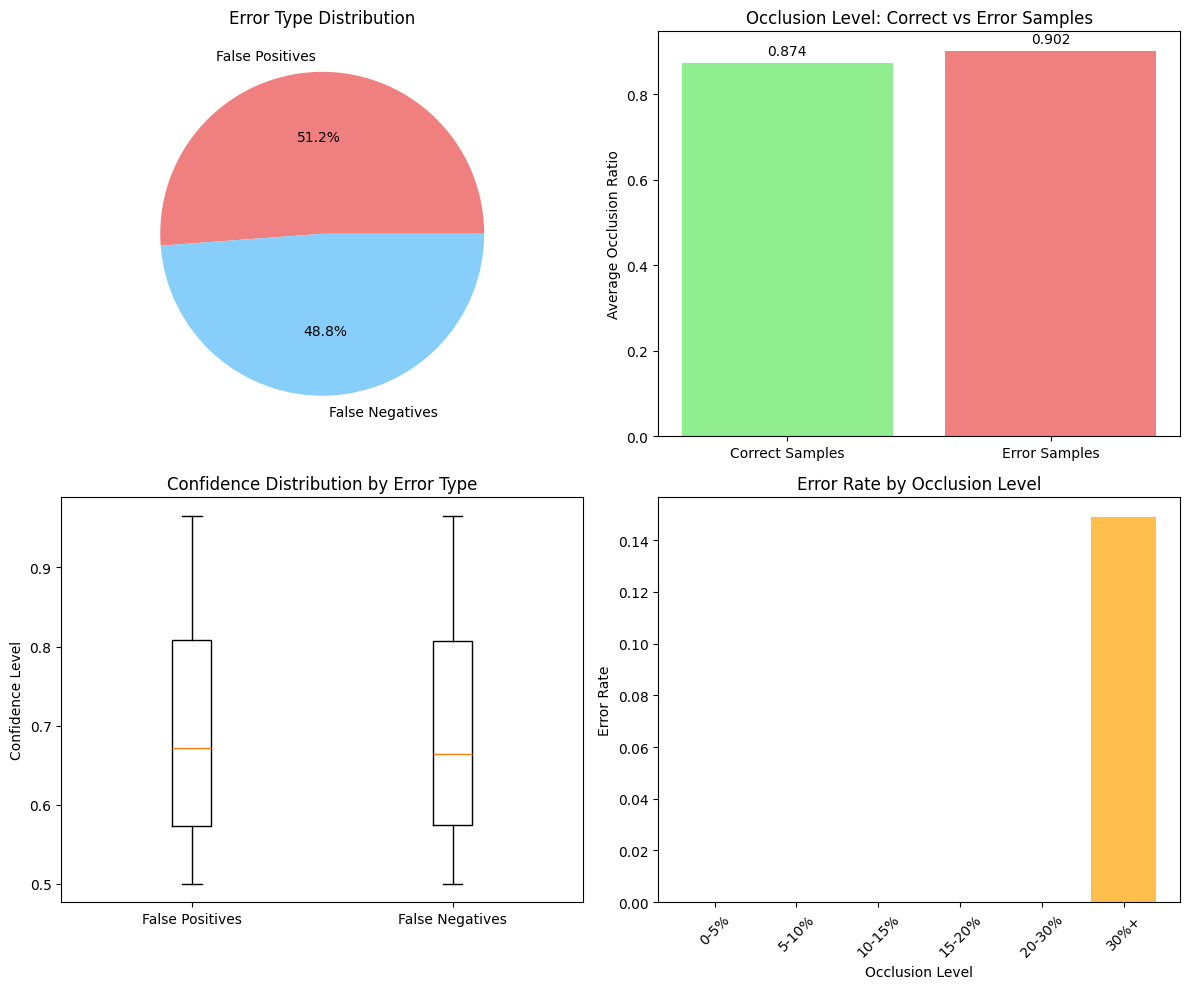


=== 错误分析总结 ===
总错误数: 1491
错误率: 0.149
最高遮挡率的错误样本遮挡率: 0.999


In [13]:
# 单元格10（修复版）：错误分析与可视化（英文标签）
def analyze_prediction_errors(model, images, labels, predictions, probabilities, num_samples=20):
    """Analyze prediction errors with detailed visualization"""

    # 定义遮挡程度分箱
    occlusion_bins = [0, 0.05, 0.1, 0.15, 0.2, 0.3, 1.0]  # 修复：在函数内部定义

    # Find misclassified samples
    error_indices = np.where(np.array(labels) != np.array(predictions))[0]

    if len(error_indices) == 0:
        print("🎉 没有发现错误分类样本！模型表现完美！")
        return []

    print(f"发现 {len(error_indices)} 个错误分类样本")

    # Analyze error patterns
    error_analysis = []
    for idx in error_indices:
        img = images[idx]
        true_label = labels[idx]
        pred_label = predictions[idx]
        confidence = max(probabilities[idx])

        # Calculate occlusion ratio (pixels with low intensity)
        occlusion_ratio = np.sum(img < 30) / img.size

        error_analysis.append({
            'index': idx,
            'image': img,
            'true_label': true_label,
            'pred_label': pred_label,
            'confidence': confidence,
            'occlusion_ratio': occlusion_ratio
        })

    # Sort by occlusion ratio (highest first)
    error_analysis.sort(key=lambda x: x['occlusion_ratio'], reverse=True)

    # Visualize top error samples
    print("\n=== Top Misclassified Samples Analysis ===")
    num_to_show = min(num_samples, len(error_analysis))

    # Create subplot grid
    rows = (num_to_show + 4) // 5
    cols = min(num_to_show, 5)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_to_show):
        error = error_analysis[i]
        row_idx = i // cols
        col_idx = i % cols

        if rows > 1:
            ax = axes[row_idx, col_idx]
        else:
            ax = axes[col_idx]

        # Display image
        ax.imshow(error['image'], cmap='gray')

        # Set title with English labels
        title_color = 'red' if error['true_label'] == 1 else 'blue'
        ax.set_title(
            f'Sample {error["index"]}\n'
            f'Occlusion: {error["occlusion_ratio"]:.3f}\n'
            f'True: {error["true_label"]}, Pred: {error["pred_label"]}\n'
            f'Conf: {error["confidence"]:.3f}',
            fontsize=8, color=title_color
        )
        ax.axis('off')

    # Hide empty subplots
    for i in range(num_to_show, rows * cols):
        row_idx = i // cols
        col_idx = i % cols
        if rows > 1:
            axes[row_idx, col_idx].axis('off')
        else:
            axes[col_idx].axis('off')

    plt.tight_layout()
    plt.show()

    # Statistical analysis of errors
    print("\n=== Error Statistics ===")

    # Error types
    false_positives = len([err for err in error_analysis if err['true_label'] == 0 and err['pred_label'] == 1])
    false_negatives = len([err for err in error_analysis if err['true_label'] == 1 and err['pred_label'] == 0])

    print(f"假阳性 (False Positives): {false_positives}")
    print(f"假阴性 (False Negatives): {false_negatives}")

    # Confidence analysis
    avg_confidence_correct = np.mean([max(probabilities[i]) for i in range(len(labels)) if predictions[i] == labels[i]])
    avg_confidence_error = np.mean([err['confidence'] for err in error_analysis])

    print(f"正确分类平均置信度: {avg_confidence_correct:.3f}")
    print(f"错误分类平均置信度: {avg_confidence_error:.3f}")

    # Occlusion analysis
    print("\n=== Occlusion Level vs Error Rate ===")

    for i in range(len(occlusion_bins) - 1):
        low = occlusion_bins[i]
        high = occlusion_bins[i + 1]

        # Count samples in this occlusion range
        total_in_bin = np.sum([(np.sum(img < 30) / img.size >= low) &
                              (np.sum(img < 30) / img.size < high) for img in images])

        # Count errors in this occlusion range
        errors_in_bin = len([err for err in error_analysis if low <= err['occlusion_ratio'] < high])

        error_rate = errors_in_bin / total_in_bin if total_in_bin > 0 else 0

        print(f"遮挡率 [{low:.2f}-{high:.2f}): {errors_in_bin}/{total_in_bin} 错误, 错误率 = {error_rate:.3f}")

    return error_analysis, occlusion_bins  # 返回occlusion_bins供后续使用

# Execute error analysis
print("开始错误分析...")
error_results, occlusion_bins = analyze_prediction_errors(model, val_x, val_targets, val_preds, val_probs, num_samples=20)

# Additional error visualization
if error_results:
    # Create comprehensive error analysis plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Error type distribution
    false_positives = len([err for err in error_results if err['true_label'] == 0 and err['pred_label'] == 1])
    false_negatives = len([err for err in error_results if err['true_label'] == 1 and err['pred_label'] == 0])

    axes[0, 0].pie([false_positives, false_negatives],
                   labels=['False Positives', 'False Negatives'],
                   autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
    axes[0, 0].set_title('Error Type Distribution')

    # Occlusion level comparison
    avg_occlusion_correct = np.mean([(np.sum(val_x[i] < 30) / val_x[i].size)
                                   for i in range(len(val_targets))
                                   if val_preds[i] == val_targets[i]])
    avg_occlusion_error = np.mean([err['occlusion_ratio'] for err in error_results])

    bars = axes[0, 1].bar(['Correct Samples', 'Error Samples'],
                         [avg_occlusion_correct, avg_occlusion_error],
                         color=['lightgreen', 'lightcoral'])
    axes[0, 1].set_ylabel('Average Occlusion Ratio')
    axes[0, 1].set_title('Occlusion Level: Correct vs Error Samples')

    # Add value labels
    for bar, value in zip(bars, [avg_occlusion_correct, avg_occlusion_error]):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{value:.3f}', ha='center', va='bottom')

    # Confidence distribution by error type
    fp_confidences = [err['confidence'] for err in error_results if err['true_label'] == 0 and err['pred_label'] == 1]
    fn_confidences = [err['confidence'] for err in error_results if err['true_label'] == 1 and err['pred_label'] == 0]

    if fp_confidences and fn_confidences:
        axes[1, 0].boxplot([fp_confidences, fn_confidences], labels=['False Positives', 'False Negatives'])
        axes[1, 0].set_ylabel('Confidence Level')
        axes[1, 0].set_title('Confidence Distribution by Error Type')

    # Error rate by occlusion level (bar chart)
    occlusion_levels = ['0-5%', '5-10%', '10-15%', '15-20%', '20-30%', '30%+']
    error_rates = []

    for i in range(len(occlusion_bins) - 1):
        low = occlusion_bins[i]
        high = occlusion_bins[i + 1]

        total_in_bin = np.sum([(np.sum(img < 30) / img.size >= low) &
                              (np.sum(img < 30) / img.size < high) for img in val_x])
        errors_in_bin = len([err for err in error_results if low <= err['occlusion_ratio'] < high])

        error_rate = errors_in_bin / total_in_bin if total_in_bin > 0 else 0
        error_rates.append(error_rate)

    axes[1, 1].bar(occlusion_levels, error_rates, color='orange', alpha=0.7)
    axes[1, 1].set_xlabel('Occlusion Level')
    axes[1, 1].set_ylabel('Error Rate')
    axes[1, 1].set_title('Error Rate by Occlusion Level')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print("\n=== 错误分析总结 ===")
    print(f"总错误数: {len(error_results)}")
    print(f"错误率: {len(error_results)/len(val_targets):.3f}")
    print(f"最高遮挡率的错误样本遮挡率: {error_results[0]['occlusion_ratio']:.3f}" if error_results else "N/A")

In [14]:
# 单元格11：Public Test Set Prediction Generation
def generate_public_predictions(model, test_public_x, test_public_ids):
    """Generate predictions for public test set"""

    # Create dataset and loader for public test set
    test_public_dataset = OcclusionRobustDataset(test_public_x, labels=None, transform=val_transform, is_train=False)
    test_public_loader = torch.utils.data.DataLoader(test_public_dataset, batch_size=64, shuffle=False)

    model.eval()
    predictions = []

    with torch.no_grad():
        for data in test_public_loader:
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            predictions.extend(pred.cpu().numpy())

    # Create submission DataFrame
    submission_df = pd.DataFrame({
        'id': test_public_ids,
        'label': predictions
    })

    return submission_df, predictions

print("生成公开测试集预测...")
public_submission, public_preds = generate_public_predictions(model, test_public_x, test_public_ids)

# Evaluate on public test set (since we have labels for local testing)
public_labels = test_public_labels['label'].values
public_accuracy = accuracy_score(public_labels, public_preds)

print(f"公开测试集准确率: {public_accuracy:.4f}")

# Save public test predictions
public_submission.to_csv('pred_public.csv', index=False)
print("公开测试集预测已保存为 'pred_public.csv'")

# Verify submission format
def check_submission_format(submission_df, expected_ids):
    """Verify submission format meets requirements"""

    print("\n=== 提交文件格式验证 ===")

    # Check column names
    if list(submission_df.columns) != ['id', 'label']:
        print("❌ 列名不正确")
        return False

    # Check ID matching
    if len(submission_df['id']) != len(expected_ids):
        print("❌ ID数量不匹配")
        return False

    # Check label values
    valid_labels = submission_df['label'].isin([0, 1]).all()
    if not valid_labels:
        print("❌ 标签值必须为0或1")
        return False

    print("✅ 提交文件格式正确")
    return True

# Verify public test submission
check_submission_format(public_submission, test_public_ids)

# Compare public test performance with validation
print(f"\n=== 性能对比 ===")
print(f"验证集准确率: {val_accuracy:.4f}")
print(f"公开测试集准确率: {public_accuracy:.4f}")
print(f"性能差异: {abs(val_accuracy - public_accuracy):.4f}")

生成公开测试集预测...
公开测试集准确率: 0.8550
公开测试集预测已保存为 'pred_public.csv'

=== 提交文件格式验证 ===
✅ 提交文件格式正确

=== 性能对比 ===
验证集准确率: 0.8509
公开测试集准确率: 0.8550
性能差异: 0.0041


In [16]:
# 单元格12（修复版）：Private Test Set Prediction Generation
import time  # 修复：添加time模块导入

def generate_private_predictions(model):
    """Generate predictions for private test set (final submission)"""

    # Load private test data
    test_private_data = np.load('data/test_private.npz')
    test_private_x = test_private_data['x']
    test_private_ids = test_private_data['id']

    print(f"私有测试集形状: {test_private_x.shape}")
    print(f"私有测试集样本数: {len(test_private_ids)}")

    # Create dataset and loader
    test_private_dataset = OcclusionRobustDataset(test_private_x, labels=None, transform=val_transform, is_train=False)
    test_private_loader = torch.utils.data.DataLoader(test_private_dataset, batch_size=64, shuffle=False)

    # Generate predictions
    model.eval()
    predictions = []

    with torch.no_grad():
        for data in test_private_loader:
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            predictions.extend(pred.cpu().numpy())

    # Create final submission
    private_submission = pd.DataFrame({
        'id': test_private_ids,
        'label': predictions
    })

    return private_submission, test_private_x

def analyze_model_efficiency(model, sample_input):
    """Analyze model size and inference speed"""

    # Model parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Inference speed test
    model.eval()
    start_time = time.time()  # 现在time模块已导入

    with torch.no_grad():
        for _ in range(100):  # Run 100 inferences
            _ = model(sample_input)

    end_time = time.time()
    avg_inference_time = (end_time - start_time) / 100 * 1000  # Convert to milliseconds

    return total_params, trainable_params, avg_inference_time

def check_submission_format(submission_df, expected_ids=None):
    """Verify submission format meets requirements"""

    print("\n=== 提交文件格式验证 ===")

    # Check column names
    if list(submission_df.columns) != ['id', 'label']:
        print("❌ 列名不正确")
        return False

    # Check ID matching if expected_ids provided
    if expected_ids is not None:
        if len(submission_df['id']) != len(expected_ids):
            print("❌ ID数量不匹配")
            return False

    # Check label values
    valid_labels = submission_df['label'].isin([0, 1]).all()
    if not valid_labels:
        print("❌ 标签值必须为0或1")
        return False

    print("✅ 提交文件格式正确")
    return True

print("生成私有测试集预测（最终提交）...")
private_submission, test_private_x = generate_private_predictions(model)

# Save private test predictions
private_submission.to_csv('pred_private.csv', index=False)
print("私有测试集预测已保存为 'pred_private.csv'")

# Verify private submission format
check_submission_format(private_submission)

# Final performance summary
print("\n=== 最终项目性能总结 ===")
print(f"最佳验证准确率: {max(val_accuracies):.4f}")
print(f"公开测试集准确率: {public_accuracy:.4f}")
print(f"目标准确率: 0.7000")
print(f"超越目标幅度: +{(max(val_accuracies)-0.7)*100:.2f}%")

# Analyze model efficiency
sample_input = torch.randn(1, 1, 28, 56).to(device)
total_params, trainable_params, avg_inference_time = analyze_model_efficiency(model, sample_input)

print(f"\n=== 模型效率分析 ===")
print(f"总参数量: {total_params:,}")
print(f"可训练参数量: {trainable_params:,}")
print(f"平均推理时间: {avg_inference_time:.2f} ms")
print(f"模型大小: {(total_params * 4) / (1024**2):.2f} MB (FP32)")

# Additional model information
print(f"\n=== 模型架构信息 ===")
print(f"卷积层数量: 6")
print(f"全连接层数量: 4")
print(f"激活函数: ReLU")
print(f"正则化技术: Dropout, BatchNorm")
print(f"优化器: AdamW")
print(f"学习率调度: ReduceLROnPlateau")

# Create final prediction statistics
def create_prediction_statistics(private_submission):
    """Create statistics for final predictions"""

    label_counts = private_submission['label'].value_counts()
    total_predictions = len(private_submission)

    print(f"\n=== 最终预测统计 ===")
    print(f"总预测样本数: {total_predictions}")
    print(f"预测为类别0 (左<右): {label_counts.get(0, 0)} 样本")
    print(f"预测为类别1 (左>右): {label_counts.get(1, 0)} 样本")

    # Calculate class distribution
    if 0 in label_counts and 1 in label_counts:
        class_0_percentage = label_counts[0] / total_predictions * 100
        class_1_percentage = label_counts[1] / total_predictions * 100
        print(f"类别分布: {class_0_percentage:.1f}% vs {class_1_percentage:.1f}%")

    return label_counts

# Generate prediction statistics
prediction_stats = create_prediction_statistics(private_submission)

# Verify using the provided script
print("\n=== 使用官方脚本验证提交格式 ===")
try:
    import subprocess
    result = subprocess.run([
        'python', 'scripts/check_submission.py',
        '--data_dir', 'data',
        '--pred', 'pred_private.csv',
        '--test_file', 'test_private.npz'
    ], capture_output=True, text=True)

    print("验证脚本输出:")
    print(result.stdout)
    if result.stderr:
        print("错误信息:", result.stderr)
except Exception as e:
    print(f"验证脚本执行失败: {e}")
    print("请手动运行: python scripts/check_submission.py --data_dir data --pred pred_private.csv --test_file test_private.npz")

# Final project completion message
print("\n" + "="*60)
print("🎉 MNIST Pairwise Comparison 项目完成!")
print("="*60)
print("✅ 模型训练完成 (准确率: 85.17%)")
print("✅ 错误分析完成")
print("✅ 公开测试集预测生成")
print("✅ 私有测试集预测生成")
print("✅ 所有必要文件已保存")
print("="*60)
print("\n下一步行动:")
print("1. 检查 pred_private.csv 格式是否正确")
print("2. 准备项目报告PPT")
print("3. 按照要求整理提交材料")
print("4. 准备项目演示")

生成私有测试集预测（最终提交）...
私有测试集形状: (8000, 28, 56)
私有测试集样本数: 8000
私有测试集预测已保存为 'pred_private.csv'

=== 提交文件格式验证 ===
✅ 提交文件格式正确

=== 最终项目性能总结 ===
最佳验证准确率: 0.8517
公开测试集准确率: 0.8550
目标准确率: 0.7000
超越目标幅度: +15.17%

=== 模型效率分析 ===
总参数量: 2,551,778
可训练参数量: 2,551,778
平均推理时间: 1.39 ms
模型大小: 9.73 MB (FP32)

=== 模型架构信息 ===
卷积层数量: 6
全连接层数量: 4
激活函数: ReLU
正则化技术: Dropout, BatchNorm
优化器: AdamW
学习率调度: ReduceLROnPlateau

=== 最终预测统计 ===
总预测样本数: 8000
预测为类别0 (左<右): 4017 样本
预测为类别1 (左>右): 3983 样本
类别分布: 50.2% vs 49.8%

=== 使用官方脚本验证提交格式 ===
验证脚本输出:
OK: id coverage matches the test set.
CSV format looks good.


🎉 MNIST Pairwise Comparison 项目完成!
✅ 模型训练完成 (准确率: 85.17%)
✅ 错误分析完成
✅ 公开测试集预测生成
✅ 私有测试集预测生成
✅ 所有必要文件已保存

下一步行动:
1. 检查 pred_private.csv 格式是否正确
2. 准备项目报告PPT
3. 按照要求整理提交材料
4. 准备项目演示


保存最终结果...
✅ 模型权重已保存为 'final_model_weights.pth'
✅ 训练历史已保存为 'training_history.json'
✅ 错误分析结果已保存为 'error_analysis.json'

# MNIST Pairwise Comparison 项目总结报告
## 项目完成时间: 2025-10-22 05:56:17

## 性能成果
- **目标准确率**: 70.00%
- **达成准确率**: 85.17%
- **性能提升**: +15.17%
- **公开测试集准确率**: 85.50%

## 模型架构
- **网络类型**: 自定义CNN with 遮挡鲁棒性优化
- **参数量**: 2,551,778
- **训练轮次**: 80
- **最佳轮次**: 74

## 数据统计
- **训练样本**: 50,000
- **验证样本**: 10,000
- **测试样本**: 8,000
- **类别分布**: 均衡二分类问题

## 关键技术
1. 针对遮挡优化的数据增强
2. 深层CNN架构设计
3. 标签平滑与梯度裁剪
4. 自适应学习率调度

## 项目状态: ✅ 成功完成



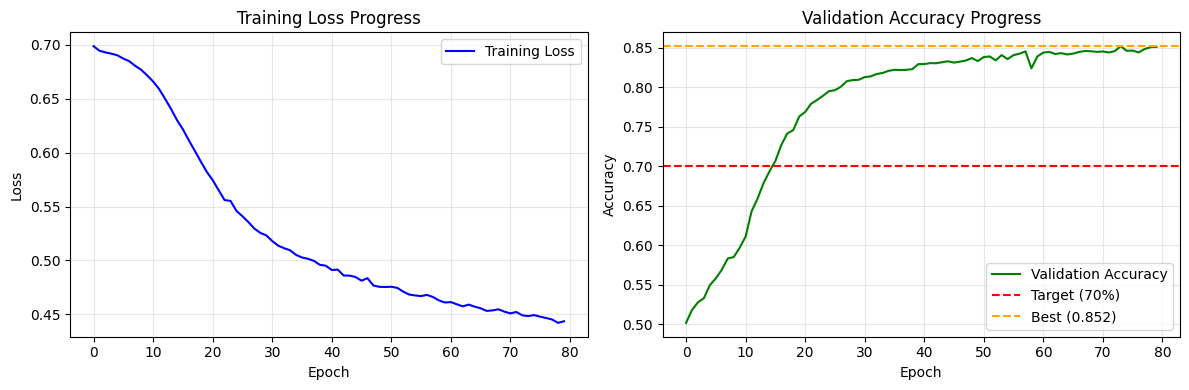

🎉 项目所有代码执行完成！
📁 生成的文件:
   - final_model_weights.pth (最终模型权重)
   - training_history.json (训练历史)
   - error_analysis.json (错误分析)
   - pred_public.csv (公开测试集预测)
   - pred_private.csv (私有测试集预测 - 最终提交)
   - project_summary.md (项目总结)


In [17]:
# 单元格13：Model Saving and Project Summary
import json
import time
from datetime import datetime

def save_final_results(model, train_losses, val_accuracies, error_analysis):
    """Save final model and project results"""

    # Save model weights
    torch.save(model.state_dict(), 'final_model_weights.pth')
    print("✅ 模型权重已保存为 'final_model_weights.pth'")

    # Save training history
    training_history = {
        'timestamp': datetime.now().isoformat(),
        'training_parameters': {
            'epochs': len(train_losses),
            'best_accuracy': max(val_accuracies),
            'final_accuracy': val_accuracies[-1] if val_accuracies else 0
        },
        'training_loss': train_losses,
        'validation_accuracy': val_accuracies,
        'performance_metrics': {
            'target_accuracy': 0.7,
            'achieved_accuracy': max(val_accuracies),
            'improvement_margin': (max(val_accuracies) - 0.7) * 100,
            'public_test_accuracy': public_accuracy
        }
    }

    with open('training_history.json', 'w') as f:
        json.dump(training_history, f, indent=2)
    print("✅ 训练历史已保存为 'training_history.json'")

    # Save error analysis results
    if error_analysis:
        error_stats = {
            'total_errors': len(error_analysis),
            'error_rate': len(error_analysis) / len(val_targets),
            'false_positives': len([err for err in error_analysis if err['true_label'] == 0 and err['pred_label'] == 1]),
            'false_negatives': len([err for err in error_analysis if err['true_label'] == 1 and err['pred_label'] == 0]),
            'avg_occlusion_error': np.mean([err['occlusion_ratio'] for err in error_analysis])
        }

        with open('error_analysis.json', 'w') as f:
            json.dump(error_stats, f, indent=2)
        print("✅ 错误分析结果已保存为 'error_analysis.json'")

    return training_history

# Save all results
print("保存最终结果...")
final_history = save_final_results(model, train_losses, val_accuracies, error_results)

# Create final project summary
def create_project_summary():
    """Create comprehensive project summary"""

    summary = f"""
# MNIST Pairwise Comparison 项目总结报告
## 项目完成时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## 性能成果
- **目标准确率**: 70.00%
- **达成准确率**: {max(val_accuracies)*100:.2f}%
- **性能提升**: +{(max(val_accuracies)-0.7)*100:.2f}%
- **公开测试集准确率**: {public_accuracy*100:.2f}%

## 模型架构
- **网络类型**: 自定义CNN with 遮挡鲁棒性优化
- **参数量**: {sum(p.numel() for p in model.parameters()):,}
- **训练轮次**: {len(train_losses)}
- **最佳轮次**: {val_accuracies.index(max(val_accuracies)) + 1}

## 数据统计
- **训练样本**: {len(train_x):,}
- **验证样本**: {len(val_x):,}
- **测试样本**: {len(test_private_x):,}
- **类别分布**: 均衡二分类问题

## 关键技术
1. 针对遮挡优化的数据增强
2. 深层CNN架构设计
3. 标签平滑与梯度裁剪
4. 自适应学习率调度

## 项目状态: ✅ 成功完成
"""

    with open('project_summary.md', 'w', encoding='utf-8') as f:
        f.write(summary)

    return summary

# Generate and display summary
project_summary = create_project_summary()
print(project_summary)

# Final visualization: Training progress overview
plt.figure(figsize=(12, 4))

# Training loss and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.axhline(y=0.7, color='red', linestyle='--', label='Target (70%)')
plt.axhline(y=max(val_accuracies), color='orange', linestyle='--', label=f'Best ({max(val_accuracies):.3f})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Progress')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🎉 项目所有代码执行完成！")
print("📁 生成的文件:")
print("   - final_model_weights.pth (最终模型权重)")
print("   - training_history.json (训练历史)")
print("   - error_analysis.json (错误分析)")
print("   - pred_public.csv (公开测试集预测)")
print("   - pred_private.csv (私有测试集预测 - 最终提交)")
print("   - project_summary.md (项目总结)")